In [3]:
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from nilearn.image import load_img, resample_to_img, coord_transform
from nilearn.plotting import view_img
from scipy.fftpack.convolve import convolve

from preprocess_nifti import *
from nilearn.datasets import fetch_atlas_aal

data_dir = 'data'
spect_dir = os.path.join(data_dir, 'phantom_spect')
nifti_dir = os.path.join(data_dir, 'phantom_spect_nifti')

In [20]:
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(spect_dir)
print(dicom_names)
reader.SetFileNames(dicom_names)
image = reader.Execute()


# print('Spacing:', image.GetSpacing())
print('Origin:', image.GetOrigin())
# print('Direction:', image.GetDirection())

def resample_3d(image3D, transform, interpolator=sitk.sitkLinear):
    resampler = sitk.ResampleImageFilter()
    resampler.SetInterpolator(interpolator)
    resampler.SetTransform(transform)
    resampler.SetOutputSpacing(image3D.GetSpacing())
    resampler.SetOutputOrigin((0.0, 0.0, 0.0))
    resampler.SetOutputDirection(image3D.GetDirection())
    resampler.SetSize(image3D.GetSize())
    return resampler.Execute(image3D)

dim = image.GetDimension()
size = list(image.GetSize())
num_channels = size[3]

# translation = tuple(coord for coord2 in image.GetOrigin()[:3])
translation = (2, 0, 16)
transform  = sitk.TranslationTransform(3, translation)

processed = []
for idx in range(num_channels):
    extract = sitk.ExtractImageFilter()
    extract.SetSize(size[:3] + [0])
    extract.SetIndex([0, 0, 0, idx])
    image_3d = extract.Execute(image)
    transformed_image_3d = resample_3d(image_3d, transform)
    print(f'After transforming')
    print('Origin:', image.GetOrigin())
    processed.append(transformed_image_3d)

join = sitk.JoinSeriesImageFilter()
transformed_image = join.Execute(processed)

print('After joining')
# print('Spacing:', transformed_image.GetSpacing())
print('Origin:', transformed_image.GetOrigin())
# print('Direction:', transformed_image.GetDirection())


sitk.WriteImage(image, os.path.join(nifti_dir, 'phantom_spect.nii'))
sitk.WriteImage(transformed_image, os.path.join(nifti_dir, 'phantom_spect_transformed.nii'))

('data\\phantom_spect/24410.0.52216046_5792.dcm',)
Origin: (-210.65241568532, -369.03986142166, -34.188960856046, 0.0)
After transforming
Origin: (-210.65241568532, -369.03986142166, -34.188960856046, 0.0)
After joining
Origin: (0.0, 0.0, 0.0, 0.0)


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\Dhruv Khanna\AppData\Local\Temp\ipykernel_12104\3223239517.py:2: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  view_img(image)



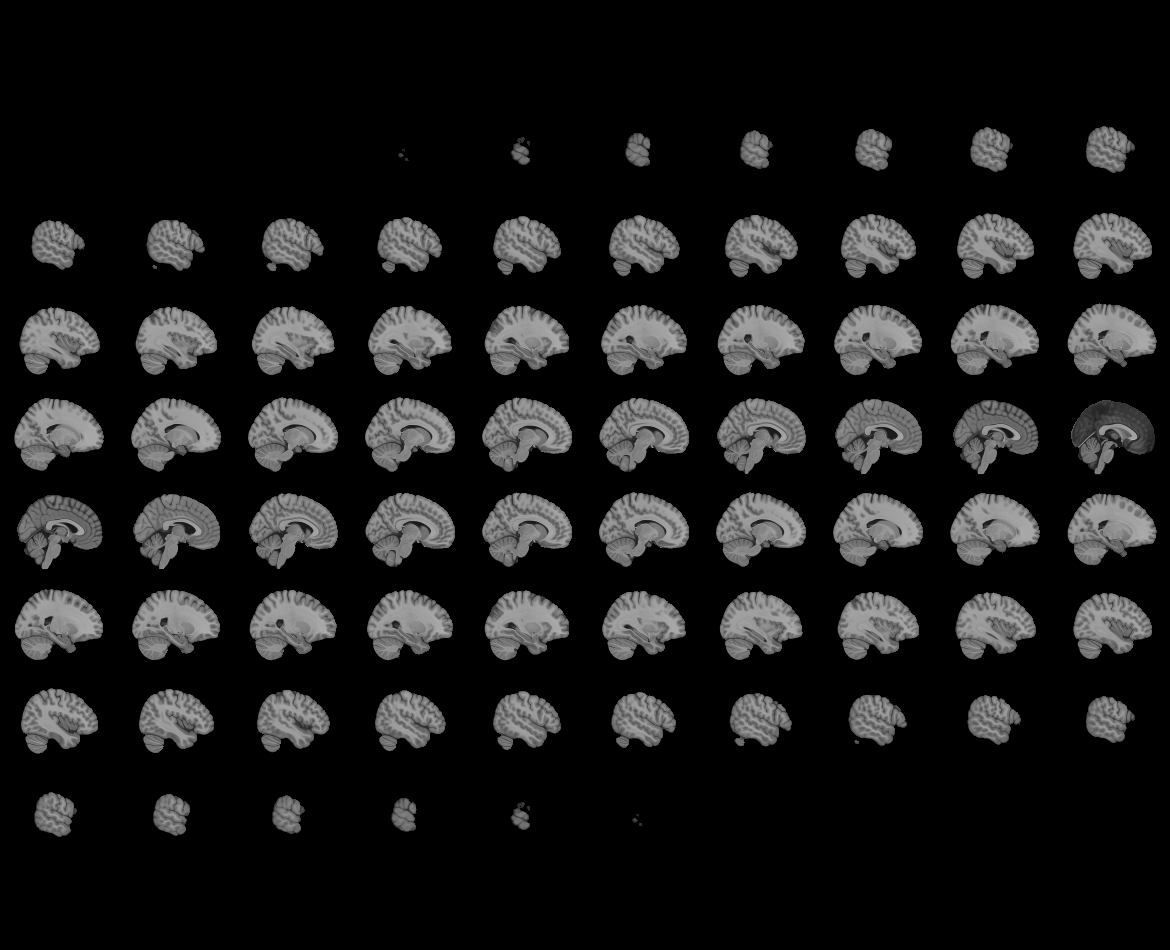
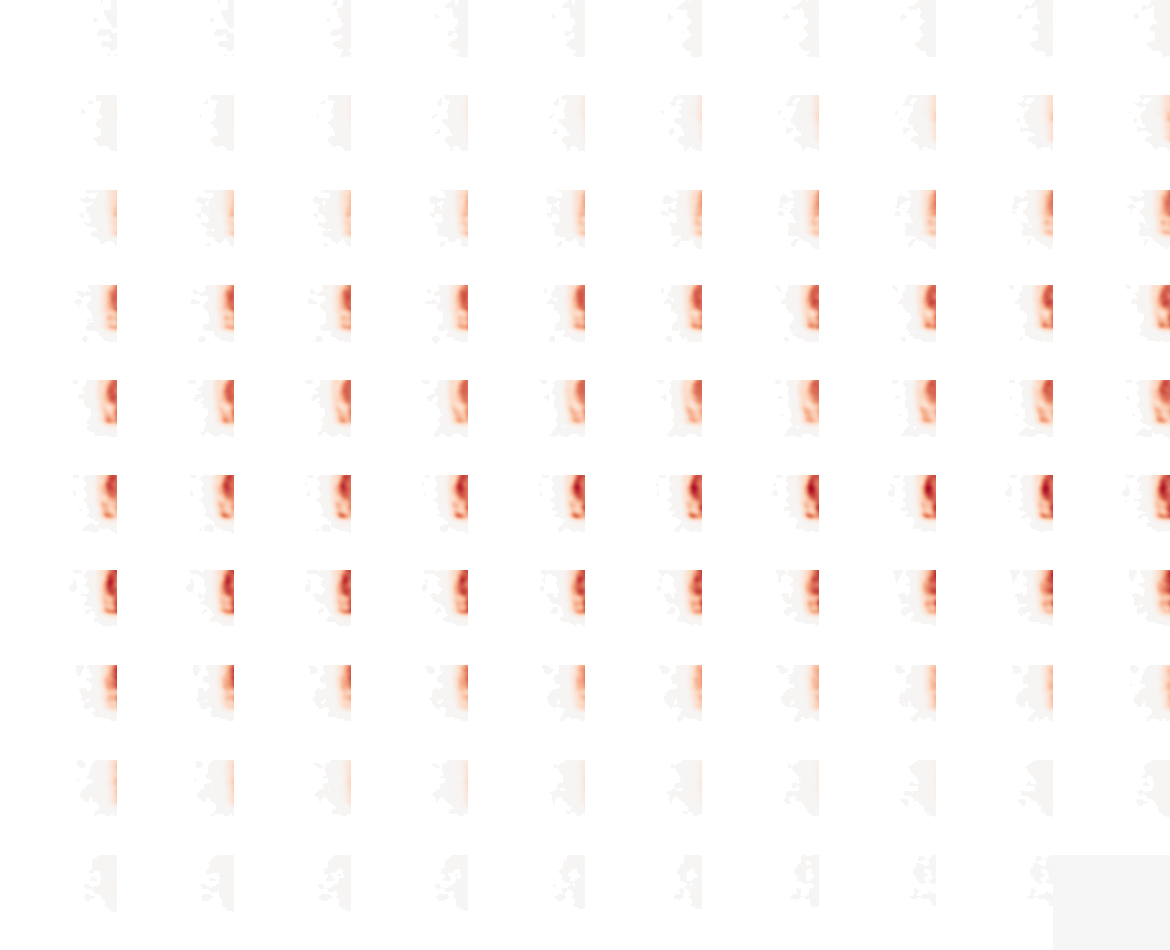

In [21]:
image = load_img(os.path.join(nifti_dir, 'phantom_spect.nii'))
view_img(image)

C:\Users\Dhruv Khanna\AppData\Local\Temp\ipykernel_12104\2607279504.py:2: UserWarning: The given float value must not exceed 0.0. But, you have given threshold=1e-06.
  view_img(image)
C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\Dhruv Khanna\AppData\Local\Temp\ipykernel_12104\2607279504.py:2: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  view_img(image)
C:\Users\Dhruv Khanna\AppData\Local\Temp\ipykernel_12104\2607279504.py:2: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  view_img(image)



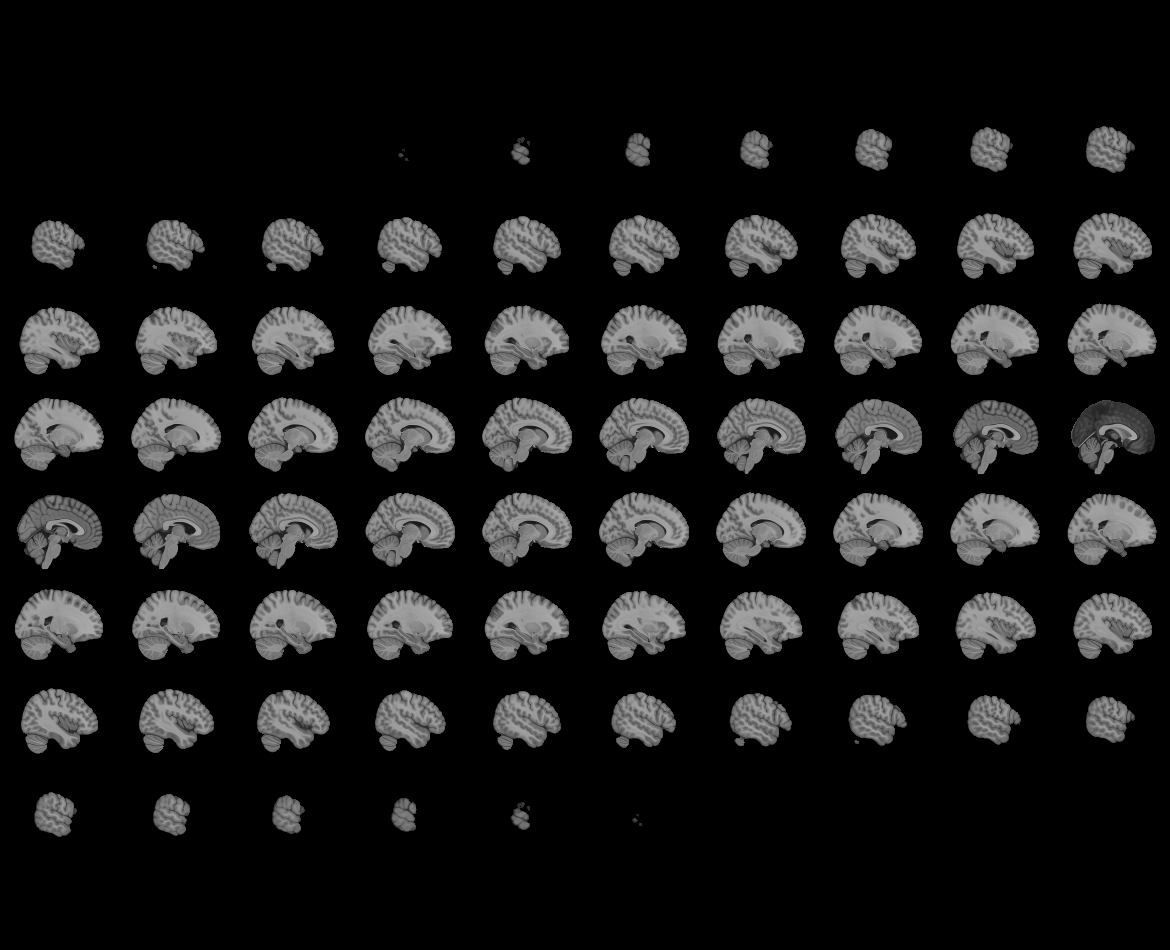
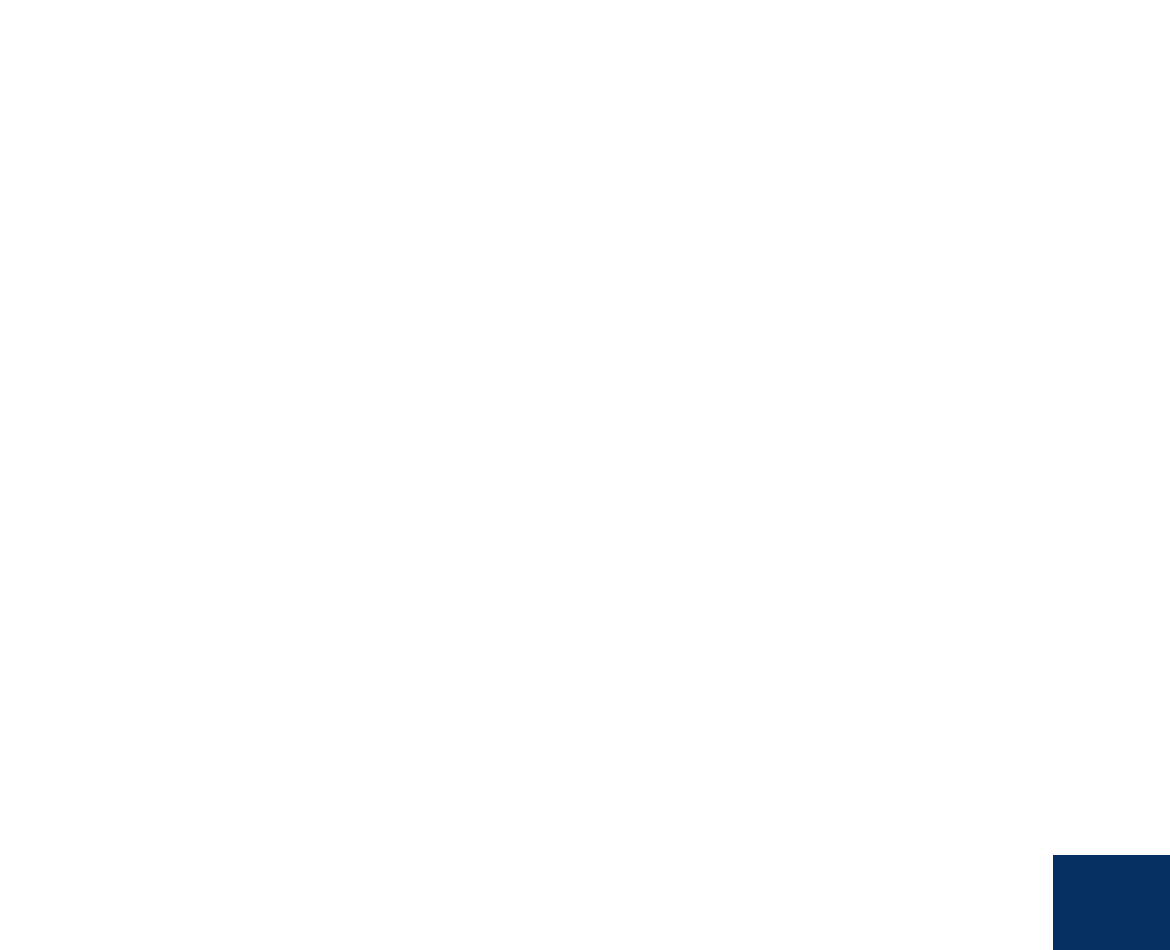

In [22]:
image = load_img(os.path.join(nifti_dir, 'phantom_spect_transformed.nii'))
view_img(image)

Min: 0.0, Max: 1929.0
Affine matrix:
 [[   2.    0.    0.  -90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
Voxel indices: (0, 23, 9)
World coordinates: (-90.00, -80.00, -54.00)


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\Dhruv Khanna\AppData\Local\Temp\ipykernel_36720\3455176617.py:20: UserWarning: Casting data from int32 to float32
  view_img(registration_img)



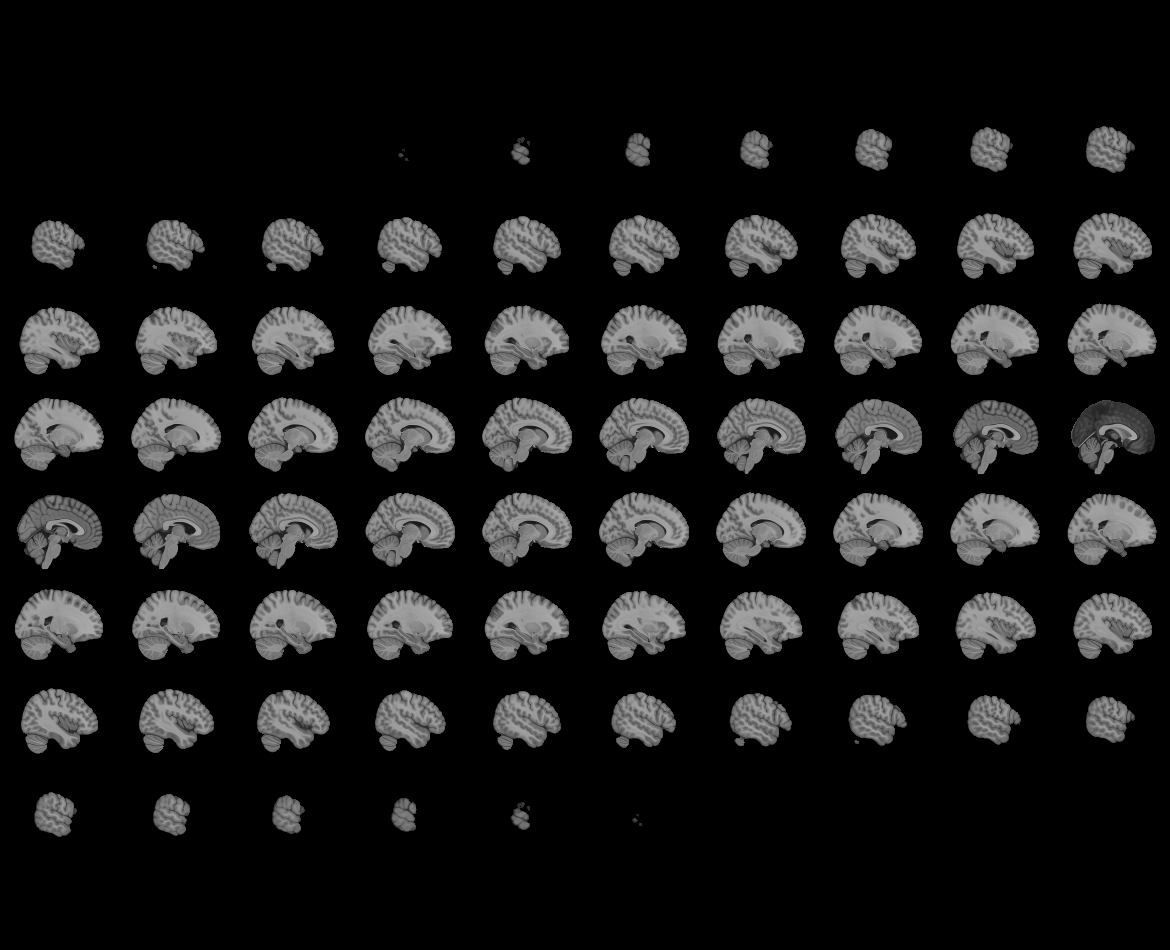
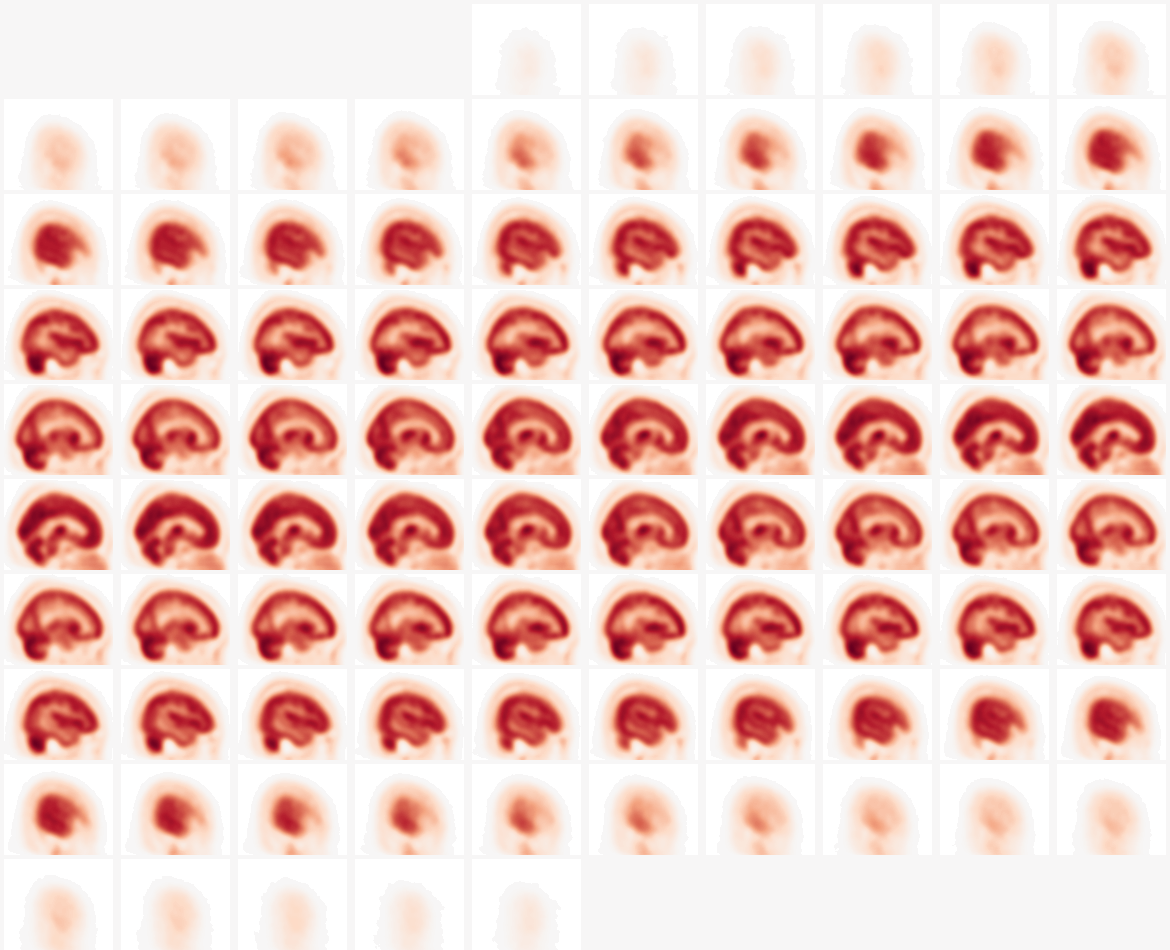

In [4]:
registration_img = load_img(os.path.join(data_dir, 'SPECT.nii'))

# Access header and affine
header = registration_img.header
affine = registration_img.affine

# Extract voxel data and choose a set of non-zero voxel indices
img_data = registration_img.get_fdata()
print(f'Min: {np.min(img_data)}, Max: {np.max(img_data)}')
i, j, k = np.array(np.where(img_data > 0))[:, 0]  # pick first non-zero voxel

# Convert to world (mm) coordinates
x, y, z = coord_transform(i, j, k, affine)

# Print affine and voxel-to-world mapping
print("Affine matrix:\n", affine)
print(f"Voxel indices: ({i}, {j}, {k})")
print(f"World coordinates: ({x:.2f}, {y:.2f}, {z:.2f})")

view_img(registration_img)


In [5]:
resampled_image = resample_to_img(image, registration_img, copy_header=True)
img_data = resampled_image.get_fdata()
print(f'Min: {np.min(img_data)}, Max: {np.max(img_data)}')
view_img(resampled_image, title='Resampled SPECT Image')


NameError: name 'image' is not defined

In [201]:

def compute_suvr(registered_img, atlas_img):
    masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=True, strategy='sum')
    masked_image = masker.fit_transform(registered_img)
    global_suv = np.sum(masked_image)
    suvrs = {region: region/global_suv for region in masked_image}
    return suvrs

In [200]:
aal = fetch_atlas_aal(version='3v2')
atlas_img = load_img(aal.maps)

roi_suvrs = compute_suvr(registration_img, atlas_img)
# print(max(roi_suvrs, key=roi_suvrs.get))
print(max(value for (item, value) in roi_suvrs.items()))
print(min(value for (item, value) in roi_suvrs.items()))
print(roi_suvrs)

[fetch_atlas_aal] Dataset found in C:\Users\Dhruv Khanna\nilearn_data\aal_3v2

Global suv: 240384248.0
0.027413227176183358
5.782408837371075e-06
{np.float64(4282213.0): np.float64(0.017814033305543382), np.float64(4112076.0): np.float64(0.017106262303842806), np.float64(5992606.0): np.float64(0.024929279059915772), np.float64(6439281.0): np.float64(0.02678744989979543), np.float64(5660138.0): np.float64(0.02354621006614377), np.float64(6224287.0): np.float64(0.02589307349290208), np.float64(1323449.0): np.float64(0.005505556254251734), np.float64(1814222.0): np.float64(0.007547175054498579), np.float64(3326666.0): np.float64(0.013838951710346678), np.float64(2718116.0): np.float64(0.011307379841294759), np.float64(1134571.0): np.float64(0.0047198225733992355), np.float64(1144973.0): np.float64(0.004763094959533289), np.float64(1336782.0): np.float64(0.005561021619020561), np.float64(1786025.0): np.float64(0.007429875355227103), np.float64(2805247.0): np.float64(0.011669845355258054), np.float64(3136928.0): np.float64(0.013049640424026452), np.float64(375314.0): 

C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\joblib\memory.py:326: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  return self.func(*args, **kwargs)
